In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import os

# Class & Function Definitions

#### 1. Graphs

In [2]:
class Vertex:
    def __init__(self, id_=""):
        self.id_ = id_
        self.neighbours = {}
    
    def add_neighbour(self, nbr_vertex, weight=0):
        self.neighbours[nbr_vertex] = weight
    
    def get_vertex_neighbours(self):
        return self.neighbours.keys()
    
    def get_weight(self, neighbour):
        if neighbour in self.neighbours.keys():
            return self.neighbours[neighbour]
        return None
    
    def __eq__(self, other):
        return self.id_ == other.id_

    def __lt__(self, other):
        return self.id_ < other.id_

    def __hash__(self):
        return hash(self.id_)
    
    def __str__(self):
        my_string = f"Vertex {self.id_} is connected to: "
        my_neighbours = [vertex.id_ for vertex in self.get_vertex_neighbours()]
        my_string += ", ".join(my_neighbours)
        return my_string
    
class Graph:
    def __init__(self):
        self.vertices = {}
        
    def _create_vertex(self, id_):
        return Vertex(id_)

    def add_vertex(self, id_):
        self.vertices[id_] = self._create_vertex(id_)

    def get_vertex(self, id_):
        return self.vertices.get(id_, None)
        
    def add_edge(self, start_v, end_v, weight=0):
        if start_v not in self.vertices: 
            self.add_vertex(start_v)
        if end_v not in self.vertices: 
            self.add_vertex(end_v)
        v_start = self.vertices[start_v]
        v_end = self.vertices[end_v]
        v_start.add_neighbour(v_end)

    def get_neighbours(self, id_):
        vertex = self.get_vertex(id_)
        if vertex:
            return [neighbour.id_ for neighbour in vertex.get_vertex_neighbours()]
        return []
 
    def __contains__(self, id_):
        return id_ in self.vertices
    
    def __iter__(self):
        return iter(self.vertices.values())

    @property        
    def num_vertices(self):
        return len(self.vertices)

In [3]:
def generate_probabilities(D=0.5, n=10):
    """ 
    Generates the probabilities of arc (i,j) existing for all i, j in n where i =/= j 
    Probability values are generated based on (Hall & Posner, 2001)
    Inputs: 
        - D          : float, value between 0 and 1 which sets the density of the graph
        - n          : int, number of nodes to be generated
    Output: 
        Returns p_ij, a dictionary which stores the probability values using the following data structure: 
            p_ij = { i: {j: p_ij} }
    """
    p_ij = {}
    n = int(n)
    for i in range(1, n+1):
        p_ij[i] = {}
        for j in range(1, n+1):
            if j != i: 
                p_ij[i][j] = D*(1-D)**(j-i-1) / (1 - D * (1 - (1-D)**(j-i-1) ))
    return p_ij 

def generate_graph(n, p_ij, dict_graph={}):
    """ 
    Generates a new graph with arcs and nodes that represent a BOM network. 
    The BOM network is generated based on a given set of probability values (Hall & Posner, 2001)
    Inputs: 
        - n          : int, number of nodes in the graph 
        - p_ij       : dict, probability of arc (i,j) existing (p_ij = { i: {j: p_ij}})
        - dict_graph : dict, alternative method to store graph information using adjacency matrix 
    Output: 
        - g          : graph object containing node and edges information
        - dict_graph : no output, but dict_graph is processed in place 
    Specific Features:
        - The graph generated does not contain self-connecting cycles
    """

    g = Graph()
    edges = []

    for i in range(1, n):
        dict_graph[str(i)] = []
        for j in range(i + 1, n + 1):
            dict_graph[str(j)] = []
            if p_ij[i][j] <= random.random():
                edges.append((i, j))

    for u, v in edges:
        u, v = str(u), str(v)
        if u < v:
            if not any(g.get_vertex(str(w)) for w in g.get_neighbours(v) if g.get_vertex(u) in g.get_neighbours(w)):
                g.add_edge(u, v)
                dict_graph[u].append(v)
        else:
            if not any(g.get_vertex(str(w)) for w in g.get_neighbours(u) if g.get_vertex(v) in g.get_neighbours(w)):
                g.add_edge(u, v)
                dict_graph[u].append(v)
    return g

def visualize_graph(graph, figure_size=(8, 6), font_type="Century Gothic", font_size=15, node_size=1500, node_color='lightblue', edge_color='black', alpha=1, folder_path=None, file_name=None):
    """ 
    Generates a visualization for a graph object. The visualization is made in such a way that: 
        (1) Nodes with no immediate predecessors are placed to the left of the image
        (2) Nodes with no immediate successors are placed to the right of the image 
        (3) All other remaining nodes are placed in between. 
    Inputs (Required): 
        - graph         : graph object, containing the nodes and edges to be visualized
    Inputs (Optional):
        - figure_size   : tuple, sets the preferred size of the image
        - font_type     : str, sets the font family
        - font_size     : float, sets the size of the font
        - node_size     : float, sets the size of the nodes
        - node_color    : str, sets the color of the nodes
        - edge_color    : str, sets the color of the edges
        - edge_alpha    : float, value between 0 and 1 which sets the density of the edges
    Output: 
        - Visualization of the graph using plt.show()
    """
    G = nx.DiGraph()
    
    for vertex in graph:
        G.add_node(vertex.id_)
        for neighbour in vertex.get_vertex_neighbours():
            G.add_edge(vertex.id_, neighbour.id_)
    
    # Create custom positions for nodes
    pos = {}
    nodes_without_predecessors = [node for node in G.nodes if G.in_degree(node) == 0]
    nodes_without_successors = [node for node in G.nodes if G.out_degree(node) == 0]
    other_nodes = [node for node in G.nodes if node not in nodes_without_predecessors and node not in nodes_without_successors]
    
    # Assign layers
    layers = {node: 0 for node in nodes_without_predecessors}
    for node in other_nodes:
        predecessors = G.predecessors(node)
        layers[node] = max(layers[pred] + 1 for pred in predecessors if pred in layers)
    for node in nodes_without_successors:
        predecessors = G.predecessors(node)
        layers[node] = max(layers[pred] + 1 for pred in predecessors if pred in layers)
    
    # Add subset attribute to nodes
    for node, layer in layers.items():
        G.nodes[node]['subset'] = layer
    
    # Assign positions using multipartite_layout
    pos = nx.multipartite_layout(G, subset_key='subset')
    
    # Draw the graph with custom positions
    plt.figure(figsize=figure_size)
    nx.draw(G, pos, with_labels=True, font_family=font_type, font_weight='bold', font_size=font_size,
            node_color=node_color, node_size=node_size,  
            edge_color=edge_color, alpha=alpha)
    if folder_path and file_name:
        plt.savefig(f"{folder_path}//{file_name}.png")
        plt.show()
        plt.close()
    else:
        plt.show()


### 2. Machine Speeds

In [4]:
class LogarithmicDistribution:
    def __init__(self, p):
        if not (0 < p < 1):
            raise ValueError("Parameter p must be between 0 and 1.")
        self.p = p

    def pmf(self, k):
        """Probability mass function of the logarithmic distribution."""
        if k < 1:
            return 0
        return -self.p**k / (k * np.log(1 - self.p))

    def sample(self, size=1):
        """Generate random samples from the logarithmic distribution."""
        # Using inverse transform sampling
        samples = []
        for _ in range(size):
            u = np.random.uniform(0, 1)
            k = 1
            sum_pmf = self.pmf(k)
            while u > sum_pmf:
                k += 1
                sum_pmf += self.pmf(k)
            samples.append(k)
        return np.array(samples)

    def plot_pmf(self, max_k=20):
        """Plot the probability mass function."""
        ks = np.arange(1, max_k + 1)
        pmf_values = [self.pmf(k) for k in ks]
        plt.stem(ks, pmf_values, use_line_collection=True)
        plt.xlabel('k')
        plt.ylabel('P(X=k)')
        plt.title('Logarithmic Distribution PMF')
        plt.show()

In [5]:
def plot_histogram(data, bins=10, title='Histogram', xlabel='Value', ylabel='Frequency'):
    """
    Plots a histogram of the given data.

    Parameters:
    - data: array-like, the input array of numbers.
    - bins: int, the number of bins for the histogram.
    - title: str, the title of the plot.
    - xlabel: str, the label for the x-axis.
    - ylabel: str, the label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


### 3. Machine Routing

In [6]:
def generate_transition_matrix(M, bottleneck_machine=None, bottleneck_probability=0.3):
    """
    Generate a transition matrix for machine assignments.
    Inputs:
        - M                         : int, number of machines
        - bottleneck_machine        : int or None, index of the bottleneck machine (0-indexed)
        - bottleneck_probability    : float, probability that the bottleneck machine will be chosen
    Output:
        - transition_matrix         : numpy array of shape (M, M) containing transition probabilities
    """
    transition_matrix = np.ones((M, M))
    if bottleneck_machine is not None:
        bottleneck_machine -= 1  # Convert to 0-indexed
        transition_matrix[:, bottleneck_machine] = bottleneck_probability
        other_probability = (1 - bottleneck_probability) / (M - 1)
        for i in range(M):
            if i != bottleneck_machine:
                transition_matrix[:, i] = other_probability
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1)[:, np.newaxis]
    return transition_matrix

def assign_machines(df, M, bottleneck_machine=None, bottleneck_probability=0.3):
    """
    Assign machines to operations based on a transition probability matrix.
    Inputs:
        - df                        : DataFrame, containing the operations and their predecessors
        - M                         : int, number of machines
        - bottleneck_machine        : int or None, index of the bottleneck machine (0-indexed)
        - bottleneck_probability    : float, probability that the bottleneck machine will be chosen
    Output:
        - df                        : DataFrame, with an additional column "machine" assigned
    """
    transition_matrix = generate_transition_matrix(M, bottleneck_machine, bottleneck_probability)
    current_machine = random.randint(0, M - 1)  # Start with a random machine (0-indexed)

    machine_assignments = []
    for _ in range(len(df)):
        next_machine = np.random.choice(M, p=transition_matrix[current_machine])
        machine_assignments.append(next_machine + 1)  # Convert to 1-indexed
        current_machine = next_machine
    
    df['machine'] = machine_assignments
    return df

# Data Generation

In [7]:
def generate_dataset(n, M, D, p, folder_path, file_name, bottleneck_machine=None, display_graph=False):
    # Generating the precedence operation network  
    p_ij = generate_probabilities(D=D, n=n)
    dict_graph = {}
    g = generate_graph(n, p_ij, dict_graph)
    fig_size = (24, 18) if n >= 30 else (12, 9) if n > 15 else (8, 6) 
    if display_graph:
        visualize_graph(g, figure_size=(8, 6), folder_path=folder_path, file_name=file_name)

    # Generating the operation processing times
    log_dist = LogarithmicDistribution(p)
    processing_times = 30/log_dist.sample(n)

    # Generating the machine routing
    df = pd.DataFrame({
        "operation": [None] * n,
        "predecessors": [None] * n,
        "procesing_time": processing_times
    })
    reversed_graph = {str(i): [] for i in range(1, len(dict_graph))} # graph reversed to ease next part
    for predecessor, successors in dict_graph.items():
        for successor in successors:
            reversed_graph.setdefault(successor, []).append(predecessor)
    i = 0
    for successor in reversed_graph.keys():
        df.at[i, "operation"] = successor
        df.at[i, "predecessors"] = reversed_graph[successor]
        i += 1
    df = assign_machines(df, M, bottleneck_machine, bottleneck_probability=0.7)


    return df 

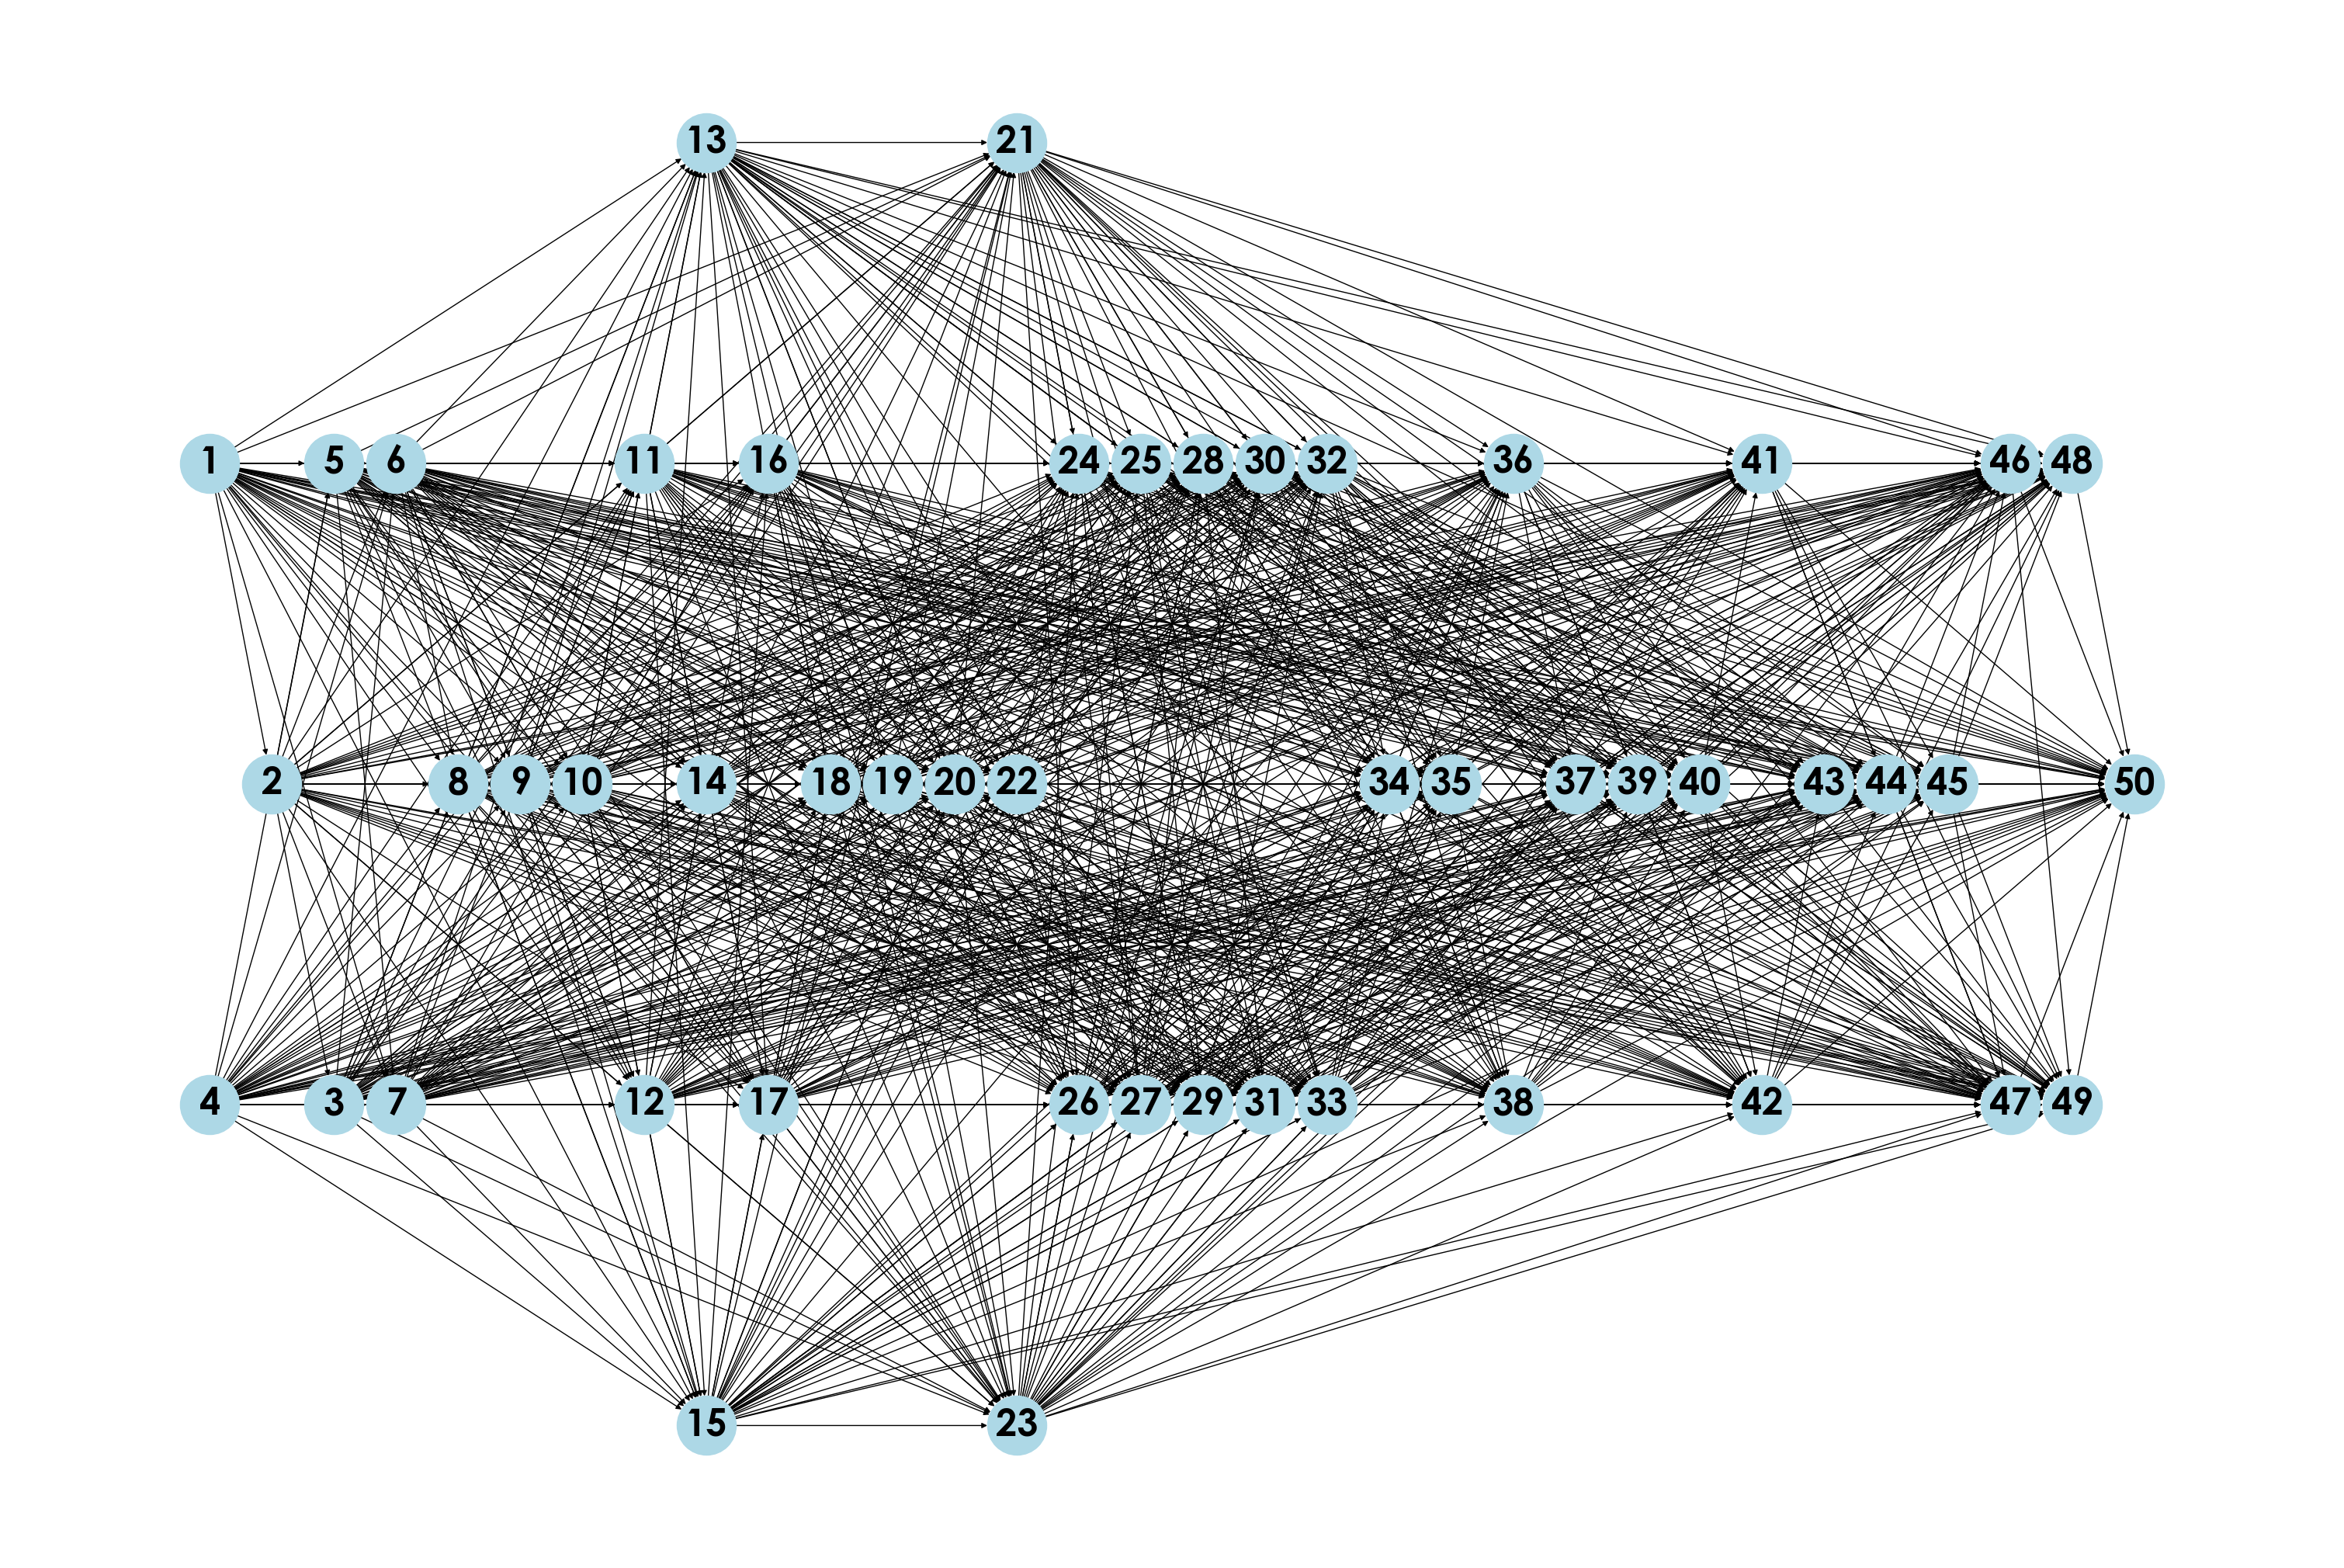

In [12]:
# Sample Implementation
D = 0.45
n = 50
p_ij = generate_probabilities(D=D, n=n)
dict_graph = {}
g = generate_graph(n, p_ij, dict_graph)
folder_path = "03_Randomized"
file_name = "output"
visualize_graph(g, figure_size=(30, 20), font_size=35, node_size=3000, folder_path=folder_path, file_name=file_name)

In [46]:
list_n = [200,100,50,30,15]
list_p = [0.15, 0.4, 0.75, 0.95]
list_M = [1, 2, 5, 10, 20]

for n in list_n: 
    display = False if n >= 50 else True
    for M in list_M: 
        folder_path = f"03_Randomized//{n}_operations//{M}_machines"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        for D in range(1,10):
            D /= 10
            for p in list_p:
                filename = f"{M}machines_{p}p_{D}D"
                df = generate_dataset(n, M, D, p, folder_path, filename, bottleneck_machine=None, display_graph=display)
                df.to_csv(f"{folder_path}//{filename}.csv", index=False)

                if M > 1:                 
                    df = generate_dataset(n, M, D, p, folder_path, filename, bottleneck_machine=random.randint(1, M), display_graph=display)
                    filename = f"{M}machines_{p}p_{D}D_bottleneck"
                    df.to_csv(f"{folder_path}//{filename}.csv", index=False)


n:200
1
2
5
10
20
n:100
1
2
5
10
20
n:50
1
2
5
10
20
n:30
1
2
5
10
20
n:15
1
2
5
10
20
